<a href="https://colab.research.google.com/github/Lingxiao-Yang/eecs442pics/blob/main/EECS_442_WN_2025_HW_4_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 442 HW4: Recognition

__Please provide the following information__
(e.g. John Doe, jdoe):

Lingxiao Yang, yanglx

In [ ]:
# TODO: Fill out your uniqname below
UNIQNAME = "yanglx"

This homework contains 5 parts:
1. Part 1: Dataset Setup [20 points]
2. Part 2: Classification [20 points]
3. Part 3: Metric Learning [50 points]
4. Part 4: Classification and Metric Learning Comparison [10 points]
5. Part 5: DIY Classification Model [20 points]

We will utilize Google Colab's limited GPU to train the models. Because of the limitation of Colab's GPU, make sure you start the homework early!

After you finish the assignment, remember to run all the cells and save the notebook to your local machine as a `.pdf` file for Gradescope submission.

The homework will be due on **March 24th at 11:59 PM**


# Colab Setup

Run the following code to import the modules you'll need.

In [ ]:
import os
import math
import random
import itertools
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from sklearn.manifold import TSNE

Make sure you are using a GPU runtime (CPU runtime works but much slower):

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Helper function to seed everything for reproducibility:

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Part 1. Dataset Setup [25 points]

In this section, we will write a custom PyTorch Dataset object to read and preprocess our images. Then, we will create some data transforms on the datasets and compile the dataset into dataloaders for training.


First, please save the dataset to your Google Drive and provide the path to it below.


In [ ]:
# Connect to your Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
############################################################################
# TODO: Provide the path to your dataset zip file here                     #
############################################################################

zip_path = "/content/drive/MyDrive/EECS442_WN2025_FaceDataSmall.zip"
!unzip -n /content/drive/MyDrive/EECS442_WN2025_FaceDataSmall.zip

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

data_path = 'EECS442_WN2025_FaceDataSmall'

Archive:  /content/drive/MyDrive/EECS442_WN2025_FaceDataSmall.zip


Next, implement the `__getitem__()` and `__len__()` function of the PyTorch Dataset.




In [ ]:
class FaceDataset(Dataset):

    def __init__(self, data_path, train, train_split=0.8, transforms=None):

        """
        Read all images paths and according labels, and performan train/validation split by class.
        The resulting image paths and labels are stored in self.images and self.labels.

        Args:
            data_path(str): The root directory of the dataset
            train(bool): If true, read training images; Otherwise, read validation images
            train_split(float): The ratio of training images
            transforms(torchvision.transforms): Data transforms

        Returns:
            img: The image at the given index
            label: The label associated with the given image
            index: The index of the image
        """

        self.data_path = data_path
        self.transforms = transforms

        # Class names and indices
        self.class_names = sorted([i for i in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, i))])
        self.idx_to_class = {idx: class_name for idx, class_name in enumerate(sorted(self.class_names))}
        self.class_to_idx = {j:i for i, j in self.idx_to_class.items()}

        # Read all images and labels
        self.images = []
        self.labels = []
        for class_name in self.class_names:
            class_folder = os.path.join(data_path, class_name)
            class_images = [os.path.join(class_folder, i) for i in os.listdir(class_folder)]
            label = self.class_names.index(class_name)
            self.images.extend(class_images)
            self.labels.extend([label]*len(class_images))

        # Train/validation split by class
        seed_everything()
        train_nums = [math.floor(Counter(self.labels)[i] * train_split) for i in self.idx_to_class.keys()]
        train_indices_perclass = [random.sample(np.where(np.array(self.labels)==i)[0].tolist(), train_num) for i, train_num in zip(self.idx_to_class.keys(), train_nums)]
        train_indices = list(itertools.chain.from_iterable(train_indices_perclass))
        if train:
            self.images = [self.images[i] for i in train_indices]
            self.labels = [self.labels[i] for i in train_indices]
        else:
            self.images = [self.images[i] for i in range(len(self.images)) if i not in train_indices]
            self.labels = [self.labels[i] for i in range(len(self.labels)) if i not in train_indices]


    def __getitem__(self, index):

        """
        Returns an example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            img: The image at the given index
            label: The label associated with the given image
            index: The index of the image
        """

        #############################################################################
        # TODO: This function loads a single image from its path and returns the    #
        #       image as an array after transforms along with its label and index.  #
        #       The __getitem__ function is called internally by the DataLoader     #
        #       function from torchvision.transforms.                               #
        #       (Hint: you can use PIL.Image)                                       #
        #############################################################################
        img_path = self.images[index]
        label = self.labels[index]
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return img, label, index


    def __len__(self):

        #############################################################################
        # TODO: Returns the size of dataset or number of examples in the dataset.   #
        #############################################################################
        length = len(self.images)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return length

Next, initialize the data transforms to be used on training and validation images:

1. We will be using pre-trained ResNet18 so we should use the [normalization parameter of ImageNet](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

1. Train transforms

    1. Resize to 128x128
    1. Random horizontal flip
    1. Color jittering (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    1. Convert to tensors
    1. Normalize
    
2. Test transforms
    1. Resize to 128x128
    1. Convert to tensors
    1. Normalize

Some resources you may find useful:
- [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html)
- [Normalization parameters](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

In [ ]:
#############################################################################
# TODO: Your code here.                                                     #
#       (Hint: you can use torchvision.transforms)                          #
#############################################################################

imagenet_mean=[0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

Next, initialize the train and validation datasets and dataloaders:

1. Use 80% images for training and 20% for validation in dataset initialization
1. Set the batch size to be 32 in the dataloader
1. Shuffle the training dataset but do not shuffle the test dataset in the dataloader

Some resources you may find useful:
- [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:
#############################################################################
# TODO: Your code here.                                                     #
#       (Hint: you can use torch.utils.data.DataLoader)                     #
#############################################################################

train_dataset = FaceDataset(data_path, train=True, train_split=0.8, transforms=train_transforms)
test_dataset = FaceDataset(data_path, train=False, train_split=0.8, transforms=test_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

TODO: **Why should we apply data augmentation into the dataset?**


**ANSWER**: By applying random transformations including rotation, flipping and color jittering, we can increase data diversity and make the trained model more robust to such variations, preventing overfitting. In this way, the model performs better to unseen data in real-world scenerios.

TODO: **What is the purpose of applying a normalization transform?**

**ANSWER**: A normalization transform converts image pixel values to a common scale before feeding into the model. This prevents issues of vanishing gradients, stabilizes & speeds up the training process and aligns new data with model expectations.

# Part 2: Classfication

In this section, we will train a parametric classifier on the dataset we got above.

First, implement the following function to:

1. Seed everything at the very first to ensure reproducible results (we provided the function called seed_everything())
1. Initialize an ImageNet pretrained ResNet18 model
1. Modify the last fc layer to have proper output dimensions

Some resources you may find useful:
- [torchvision.models.resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers)

In [ ]:
def initialize_model(out_dim, pretrained):

    """
    Initialize a ResNet18 model.

    Args:
        out_dim(int): The output dimension of the last fc layer
        pretrained(bool): Whether to use pretrained weights

    Returns:
        model: The initialized model
    """

    model = None

    #############################################################################
    # TODO: Your code here.                                                     #
    #       (Hint: you can use torchvision.models.resnet18 and torch.nn.Linear) #
    #############################################################################

    seed_everything()
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, out_dim)

    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return model

Next, implement `ClassificationTrainer` class:

Some resources you may find useful:
- [Training Loop](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [Optimizer](https://pytorch.org/docs/stable/optim.html)
- [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Saving and Loading Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [Move to device](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html)
- [Other Module Functions](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)


In [ ]:
class ClassificationTrainer():

    def __init__(self, feat_dim, pretrained):

        """
        Args:
            feat_dim(int): The feature dimension to be used, which is output dimension of the last fc layer
            pretrained(bool): Whether to use pretrained weights
        """

        self.feat_dim = feat_dim
        self.pretrained = pretrained
        self.predictions = []

        #############################################################################
        # TODO: Initialize the model through initialize_model function above.       #
        #############################################################################
        self.model = initialize_model(feat_dim, pretrained)



        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


    def train(self, loader, num_epochs=5, lr=0.001, save_filename='classification.pt', device='cuda'):

        """
        Main training loop.

        Args:
            loader(torch.utils.data.DataLoader): The training data loader
            num_epochs(int): The number of epochs to train
            lr(float): The learning rate
            save_filename(str): The filename to save the model
            device(str): The device to use
        """


        #############################################################################
        # TODO: Implement the classifier training main loop. Make sure you           #
        #       1. Set the model to train mode                                      #
        #       2. Move everything to the specified device                           #
        #       3. Use cross entropy loss and Adam optimizer with proper lr         #
        #       4. Print the running loss for every epoch                           #
        #       5. Save the resulting model weights                                 #
        #       (Hint: every argument should be used; Modules you can use:          #
        #        torch.nn.CrossEntropyLoss, torch.optim.Adam, torch.save)           #
        #############################################################################
        self.model.train()
        self.model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels, _ in loader:
              images, labels = images.to(device), labels.to(device)

              optimizer.zero_grad()
              outputs = self.model(images)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              running_loss += loss.item()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(loader)}")

        torch.save(self.model.state_dict(), save_filename)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


    def test(self, loader, checkpoint='classification.pt', device='cuda'):

        """
        Main test loop.

        Args:
            loader(torch.utils.data.DataLoader): The test data loader
            checkpoint(str): The filename of the model checkpoint to load
            device(str): The device to use
        """

        #############################################################################
        # TODO: Implement the classifier testing main loop. Make sure you            #
        #       1. Load the model if checkpoint is not None                         #
        #       2. Set the model to evaluation mode                                 #
        #       3. Move everything to the specified device                           #
        #       4. Reset self.predictions to empty array                            #
        #       5. Take the class with highest score as the prediction              #
        #       6. Save the predictions in the list self.predictions                #
        #       7. Print the overall accuracy on the test set                       #
        #       (Hint: every argument should be used)                               #
        #############################################################################
        if checkpoint:
            self.model.load_state_dict(torch.load(checkpoint, map_location=device))
        self.model.eval()
        self.model.to(device)
        self.predictions = []
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                self.predictions.extend(predicted.cpu().numpy())
        accuracy = 100 * correct / total
        print(f"Accuracy: {accuracy}%")
        return accuracy

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


    def visualize_predictions(self, dataset, checkpoint='classification.pt', device='cuda'):

        """
        Visualize the predictions for the student's images.

        Args:
            dataset(torch.utils.data.Dataset): The dataset to use
            checkpoint(str): The filename of the model checkpoint to load
            device(str): The device to use
        """

        # Find the index for the specified class name
        index = dataset.class_to_idx[UNIQNAME]

        # Identify the indices of the dataset that belong to the specified class
        train_indices = [i for i, label in enumerate(dataset.labels) if label == index]

        # Create a subset based on these indices
        subset = Subset(dataset, train_indices)

        # Create a DataLoader for the subset
        loader = DataLoader(subset, batch_size=1, shuffle=False)

        # Load the model
        state_dict = torch.load(checkpoint, map_location=device)
        self.model.load_state_dict(state_dict)
        self.model.to(device)
        self.model.eval()

        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

        # Define the normalization parameters used during training
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)

        for image, true_label, _ in loader:
            image = image.to(device)
            true_label = true_label.to(device)

            # Make prediction
            with torch.no_grad():
                output = self.model(image)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                top5_prob, top5_catid = torch.topk(probabilities, 5)
            predicted_label = top5_catid[0, 0].item()

            # Unnormalize image
            unnormalized_image = image * std + mean
            np_image = unnormalized_image.squeeze(0).cpu().numpy()
            np_image = np.transpose(np_image, (1, 2, 0))

            plt.imshow(np.clip(np_image, 0, 1))
            plt.title(f"True: {idx_to_class[true_label.item()]}, Predicted: {idx_to_class[predicted_label]}")
            plt.axis('off')
            plt.show()

            # Print the top 5 predictions and their probabilities
            print("Top 5 predictions:")
            for i in range(top5_catid.size(1)):
                predicted_class = idx_to_class[top5_catid[0, i].item()]
                probability = top5_prob[0, i].item()
                print(f"{predicted_class}: {probability:.2f}")


    def getTSNE(self, dataloader, device, checkpoint='classification.pt'):
      """
      Visualize the predictions for the student's images and return images of the three nearest classes.

      Args:
          dataloader(torch.utils.data.DataLoader): The data
          device(str): The device to use
          UNIQNAME(str): The unique name to highlight
          checkpoint(str): The filename of the model checkpoint to load

      Returns:
          nearest_class_images(list of tuples): (images, label) for the three nearest classes
      """

      # Load the model state
      if checkpoint:
          self.model.load_state_dict(torch.load(checkpoint))
      self.model.to(device)
      self.model.eval()

      # Get feature extractor by removing the last layer
      feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])

      features = []
      labels = []
      all_images = []

      # Collect features, labels, and original images
      with torch.no_grad():
          for inputs, targets, _ in tqdm(dataloader, desc="Processing", leave=False):
              inputs, targets = inputs.to(device), targets.to(device)

              outputs = feature_extractor(inputs).squeeze().cpu()
              features.append(outputs)
              labels.extend(targets.cpu().numpy())
              all_images.extend(inputs.cpu())
      features = torch.cat(features, dim=0).numpy()

      # Perform t-SNE
      tsne = TSNE(n_components=2, random_state=42)
      features_2d = tsne.fit_transform(features)

      idx_interest = [i for i, l in enumerate(labels) if dataloader.dataset.idx_to_class[l] == UNIQNAME]
      if not idx_interest:
          print(f"No data points found for the unique name: {UNIQNAME}")
          return []

      # Plot t-SNE features
      plt.figure(figsize=(10, 7))
      colormap = cm.get_cmap('jet', len(set(labels)))
      colors = [colormap(i) for i in labels]

      # Plot all points of interest
      for i in idx_interest:
          interest_point = features_2d[i]
          plt.scatter(interest_point[0], interest_point[1], marker='X', s=200,
                      facecolors='yellow', edgecolors='red', linewidths=3, alpha=1.0, label=f'{UNIQNAME} (ID: {i})')



      # Collect distinct labels
      distinct_labels = set()
      nearest_class_images = [(all_images[i], dataloader.dataset.class_to_idx[UNIQNAME]) for i in idx_interest]
      sorted_indices = np.argsort(np.linalg.norm(features_2d - features_2d[idx_interest[0]], axis=1))
      for i in sorted_indices:
          if len(distinct_labels) >= 5:
              break
          label = labels[i]
          if label not in distinct_labels and label != labels[idx_interest[0]]:
              distinct_labels.add(label)
              images_idx = [j for j, lbl in enumerate(labels) if lbl == label]
              nearest_class_images.extend([(all_images[j], label) for j in images_idx])

      for label in distinct_labels:
          idx = [i for i, l in enumerate(labels) if l == label]
          plt.scatter(features_2d[idx, 0], features_2d[idx, 1],
                      label=f'{dataloader.dataset.idx_to_class[label]}',
                      alpha=0.5, c=np.array([colors[i] for i in idx]))

      plt.title('t-SNE of Features in ResNet-18')
      plt.xlabel('Component 1')
      plt.ylabel('Component 2')
      plt.axis('equal')
      plt.legend()
      plt.show()

      return nearest_class_images


    def plot_nearest_images(self, nearest_class_images, dataloader):
      """
      Plot images of the three nearest classes identified with labels.

      Args:
          nearest_class_images (list of tuples): List of (images, label) for the three nearest classes
          dataloader (torch.utils.data.DataLoader): The data loader with image transformations
      """
      # Define the normalization parameters used during training
      mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to('cpu')
      std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to('cpu')

      idx_to_class = {v: k for k, v in dataloader.dataset.class_to_idx.items()}

      distinct_labels = list(set(label for _, label in nearest_class_images))
      num_images_to_show = 5
      fig, axes = plt.subplots(nrows=len(distinct_labels), ncols=num_images_to_show, figsize=(20, 8))

      for i, label in enumerate(distinct_labels):
          images = [img for img, lbl in nearest_class_images if lbl == label][:num_images_to_show]
          for j, image in enumerate(images):
              image_cpu = image.cpu()
              unnormalized_image = image_cpu * std + mean
              np_image = unnormalized_image.permute(1, 2, 0).numpy()
              axes[i, j].imshow(np.clip(np_image, 0, 1))
              axes[i, j].axis('off')
              axes[i, j].set_title(idx_to_class[label], fontsize=10)

      plt.tight_layout()
      plt.show()

Next, initialize the `ClassificationTrainer`:

In [ ]:
#############################################################################
# TODO: Your code here.                                                     #
#############################################################################
num_classes = len(train_dataset.class_to_idx)
classifier = ClassificationTrainer(num_classes, pretrained=True)


#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

Next, train the model. This should take a few minutes:

In [ ]:
classifier.train(train_loader, device=device)

Epoch 1/5, Loss: 2.4877101455597166
Epoch 2/5, Loss: 0.6044720812363827
Epoch 3/5, Loss: 0.33816118792016453
Epoch 4/5, Loss: 0.19918517090697238
Epoch 5/5, Loss: 0.2251778127070754


Next, evaluate the model on the validation set:

In [ ]:
classifier.test(test_loader, device=device)

Accuracy: 86.32421614409607%


86.32421614409607

Next, visualize the prediction of your trained model on your own images:

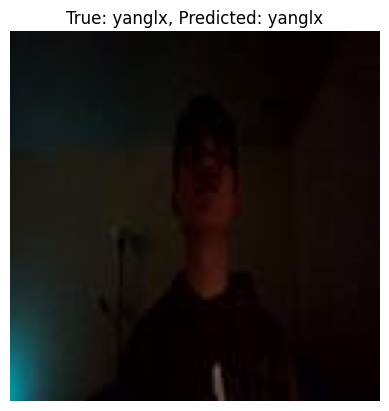

Top 5 predictions:
yanglx: 0.99
ayayang: 0.00
siruiliu: 0.00
anveshag: 0.00
ethanjus: 0.00


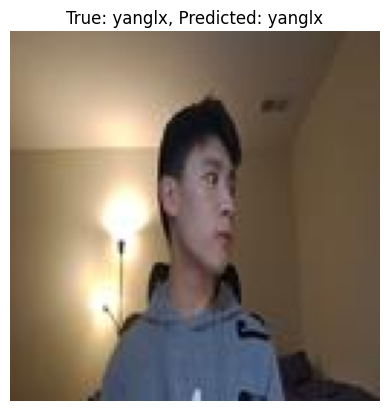

Top 5 predictions:
yanglx: 1.00
siruiliu: 0.00
loreeian: 0.00
syuanlee: 0.00
jinws: 0.00


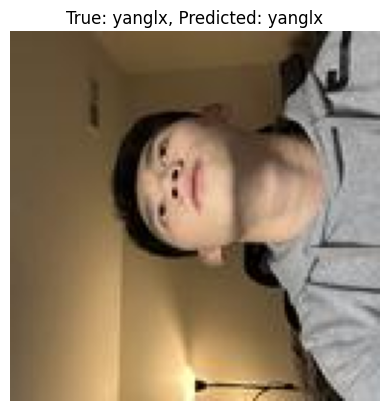

Top 5 predictions:
yanglx: 0.97
syuanlee: 0.01
siruiliu: 0.01
hylhuang: 0.00
jinws: 0.00


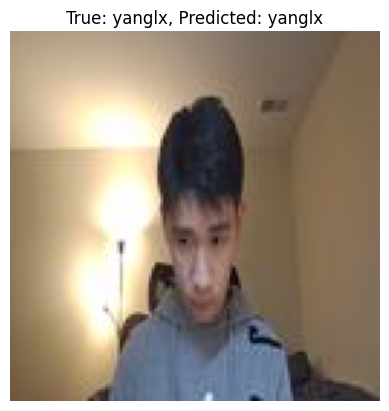

Top 5 predictions:
yanglx: 1.00
siruiliu: 0.00
kunda: 0.00
jinws: 0.00
loreeian: 0.00


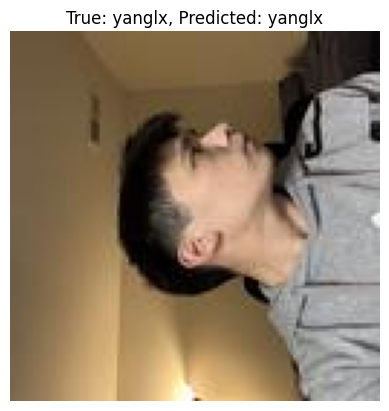

Top 5 predictions:
yanglx: 1.00
siruiliu: 0.00
syuanlee: 0.00
hylhuang: 0.00
jinws: 0.00


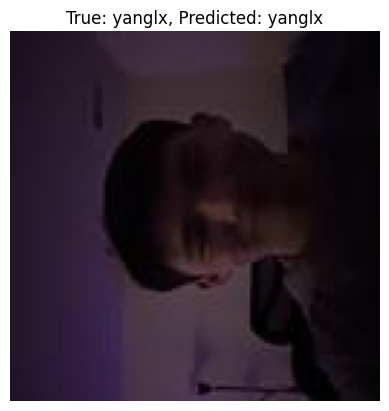

Top 5 predictions:
yanglx: 0.96
siruiliu: 0.01
ethanjus: 0.01
ayayang: 0.00
alexxu: 0.00


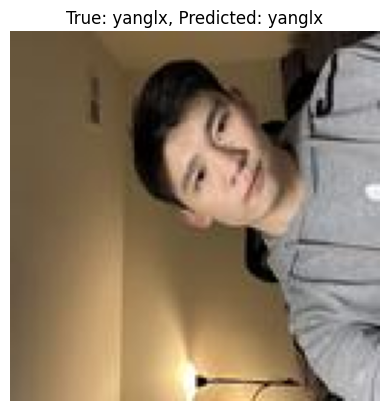

Top 5 predictions:
yanglx: 0.43
siruiliu: 0.20
syuanlee: 0.20
selinas: 0.09
hylhuang: 0.02


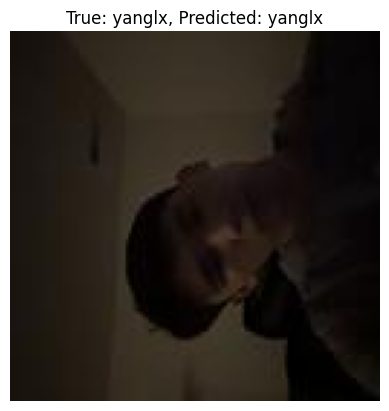

Top 5 predictions:
yanglx: 0.39
ethanjus: 0.37
siruiliu: 0.12
harmas: 0.03
sunyihan: 0.02


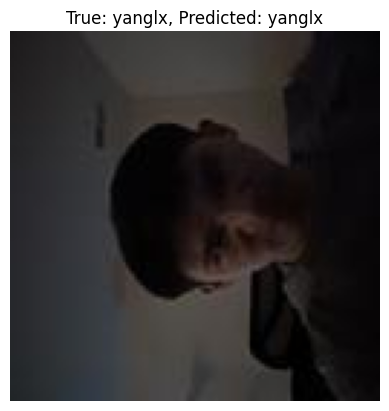

Top 5 predictions:
yanglx: 0.74
ethanjus: 0.12
sunyihan: 0.04
jialeng: 0.02
himak: 0.01


In [ ]:
classifier.visualize_predictions(test_dataset, device=device)

Your model is saved on Colab, but it will be deleted when the instance end. Be sure to download it into your local laptop to avoid the training process again. You can upload it back onto Colab later to run some functions on it without having to go through the training process again.

TODO: **How effective is the pretrained ResNet18 model in predicting your images? What may be some causes of these results?**

**ANSWER**:

The pretrained model turns out to be accurate in most cases, achieving other 90% confidence when successfully predicting my images.

However, both accuracy and confidence dropped when I either changed head position or facial expressions in dark environments. A failure has also been observed in bright conditions when I tilted my head. Both cases may cause my face to distort and make the model fail to extract my face features. Another possibility is that I actually look alike some of the classmates when making some specific postionings or expressions, thereby fooling the model.

# Part 3: Metric Learning

In this section, we will implement a simplified **NPID (Non-Parametric Instance Discrimination) metric learning model**:

**Metric learning** uses the training data to learn a model that will output an embedding. These embeddings are saved within the model as a "memory bank." During prediction time, the model takes in an image and output the embedding of the image. That embedding is then compared with the memory bank embeddings and outputs the prediction with the most similar embedding.

There are many different metric to calculate similarity, such as cosine, euclidean, etc. The **temperature** τ adjust the sharpness or smoothness of probability distributions derived from similarity scores.

We will train a metric learning model to remember the embeddings of the training data and use it to predict the most similar training data at prediction time using KNN. The similarity metric we will use is **cosine similarity**.


The model and training loop will have similar steps, with some key differences:
- The contrastive learning model consists of learning a backbone model (in our case, pretrained ResNet18) to generate the embedding and maintaining a memory bank for each training data.
- Similarly to classification, the backbone ResNet18 model will be trained using **Stochastic Gradient Descent**, but the loss function will be between the similarity of the output embedding with the temperature with each data in the bank and the corresponding **indices** of the memory bank (not label).

$$output = \frac{similarity(memory\_bank, output\_embedding)}{\tau}$$
- The memory bank will be updated using **momentum** with gradient turned off. Specifically, the update step of the memory bank is:
$$memory\_bank = momentum * memory[idx] + (1 - momentum) * output$$
where idx is the index corresponding data point in the memory bank matrix. Don't forget to **normalize** the memory after the update step.
- Instead of taking the max probability to find the label, the prediction will be using KNN to find the most frequent similarity in the memory bank with the output embedding.




Implement the kNNClassifier below:

In [ ]:
class kNNClassifier():

    def __init__(self, train_feats, train_labels):

        self.train_feats = train_feats.to(device)
        self.train_labels = train_labels

    def compute_distances_with_loops(self, test_feats, train_feats):

        """
        Compute the normalized distance between each test point and each training point using loops.

        Args:
            test_feats(torch.tensor): The test data, shape (num_test, D)
            train_feats(torch.tensor): The training data, shape (num_train, D)

        Returns:
            dists(torch.tensor): The distance matrix between test_feats and train_feats, shape (num_test, num_train)
        """
        num_test = test_feats.shape[0]
        num_train = train_feats.shape[0]
        dists = torch.zeros(num_test, num_train)

        #############################################################################
        # TODO: Your code here. Don't forget to normalize.                          #
        #       (Hint: You can use two loops to loop through each train/test data)  #
        #############################################################################

        test_feats_norm = F.normalize(test_feats, dim=1)
        train_feats_norm = F.normalize(train_feats, dim=1)

        for i in range(num_test):
            for j in range(num_train):
                cosine_sim = torch.dot(test_feats_norm[i], train_feats_norm[j])
                dists[i, j] = 1 - cosine_sim


        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return dists


    def compute_distances_no_loop(self, test_feats, train_feats):

        """
        Compute the distance between each test point and each test point using no loops.

        Args:
            test_feats(torch.tensor): The test data, shape (num_test, D)
            train_feats(torch.tensor): The training data, shape (num_train, D)

        Returns:
            dists(torch.tensor): The distance matrix between test_feats and train_feats, shape (num_test, num_train)
        """

        #############################################################################
        # TODO: Your code here. Don't forget to normalize                           #
        #       (Hint: Broadcasting)                                                #
        #############################################################################
        test_feats_norm = F.normalize(test_feats, dim=1)
        train_feats_norm = F.normalize(train_feats, dim=1)

        similarity = torch.mm(test_feats_norm, train_feats_norm.t())
        dists = 1 - similarity

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return dists


    def find_k_nearest_neighbors(self, test_feats, train_feats, K):

        """
        Find the top-K nearest neighbors in the training points for each test point.

        Args:
            test_feats(torch.tensor): The test data, shape (num_test, D)
            train_feats(torch.tensor): The training data, shape (num_train, D)
            K(int): The number of nearest neighbors to find

        Returns:
            nn_idxs(torch.tensor): The indices of the top-K nearest neighbors in the training data, shape (num_test, K)
        """

        #############################################################################
        # TODO: Your code here.                                                     #
        #       (Hint: Use compute_distances_no_loop function)                      #
        #############################################################################
        dists = self.compute_distances_no_loop(test_feats, train_feats)
        nn_idxs = torch.topk(dists, k=K, largest=False).indices

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return nn_idxs


    def predict(self, test_feats, K):

        """
        Predict the labels for each test point using kNN.

        Args:
            test_feats(torch.tensor): The test data, shape (num_test, D)
            K(int): The number of nearest neighbors to consider

        Returns:
            y_pred(torch.tensor): The predicted labels for each test point, shape (num_test,)
        """

        y_pred = torch.zeros(test_feats.shape[0], dtype=torch.long)

        #############################################################################
        # TODO: Your code here.                                                     #
        #       (Hint: Use find_k_nearest_neighbors function and Counter)            #
        #############################################################################
        nn_idxs = self.find_k_nearest_neighbors(test_feats, self.train_feats, K)

        for i in range(test_feats.shape[0]):
            nn_labels = self.train_labels[nn_idxs[i]]
            counter = Counter(nn_labels.tolist())
            y_pred[i] = counter.most_common(1)[0][0]


        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return y_pred


Now, implement the MetricLearningModel class.

Some resources you may find useful:
- [Functional Normalization](https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html)

In [ ]:
class MetricLearningModel(nn.Module):

    def __init__(self, feat_dim, memory_size, pretrained):

        """
        Args:
            feat_dim(int): The feature dimension to be used, which is output dimension of the last fc layer
            memory_size(int): The size of the memory bank
        """

        super(MetricLearningModel, self).__init__()
        self.backbone = None
        self.memory = None

        #############################################################################
        # TODO: Initialize the pretrained ResNet18 backbone and memory bank.        #
        #    Initialize the memory to random values with torch.randn                #
        #    (Hint: Use initialize_model and torch.nn.functional.normalize)         #
        #############################################################################
        self.backbone = initialize_model(feat_dim, pretrained)
        self.memory = torch.randn(memory_size, feat_dim)
        self.memory = F.normalize(self.memory, dim=1).to(device)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

    def forward(self, x):

        """
        Args:
            x(torch.Tensor): The batched input image
        """

        #############################################################################
        # TODO: Extract and normalize the feature (lies on the unit hypersphere).   #
        #       (Hint: you can use torch.nn.functional.normalize)                   #
        #############################################################################
        x = self.backbone(x)
        x = F.normalize(x, dim=1)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        return x


Then, implement the MetricLearningTrainer class.

In [ ]:
class MetricLearningTrainer():

    def __init__(self, feat_dim, memory_size, pretrained, train_loader, test_loader):

        """
        Args:
            feat_dim(int): The feature dimension to be used, which is output dimension of the last fc layer
            memory_size(int): The size of the memory bank
            pretrained(bool): Whether to use pretrained model
            train_loader(torch.utils.data.DataLoader): The training data loader
            test_loader(torch.utils.data.DataLoader): The test data loader
        """

        self.feat_dim = feat_dim
        self.memory_size = memory_size
        self.pretrained = pretrained
        self.train_loader = train_loader
        self.test_loader = test_loader

        #############################################################################
        # TODO: Initialize the model through initialize_model function above.       #
        #############################################################################
        self.model = MetricLearningModel(feat_dim, memory_size, pretrained)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

    def train(self, num_epochs=5, lr=0.05, temperature=0.07, memory_momentum=0.99, save_filename='metric_learning.pt', device='cuda'):

        """
        Main training loop.

        Args:
            num_epochs(int): The number of epochs to train
            lr(float): The learning rate
            temperature(float): The temperature for the softmax function
            save_filename(str): The filename to save the model
            device(str): The device to use
        """

        #############################################################################
        # TODO: Your code here.                                                     #
        #       (Hint: you can use torch.nn.CrossEntropyLoss and torch.optim.Adam)  #
        #       (Hint: you can calculate the similarity of the output embedding     #
        #       and the memory bank using torch.matmul. Remember the tensors are    #
        #       normalized)                                                         #
        #############################################################################

        self.model.to(device)
        self.model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels, indices in tqdm(self.train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
                images, labels, indices = images.to(device), labels.to(device), indices.to(device)

                features = self.model(images)
                similarity = torch.matmul(features, self.model.memory.t()) / temperature

                loss = criterion(similarity, indices)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    batch_memory = self.model.memory[indices]
                    updated  = memory_momentum * batch_memory + (1 - memory_momentum) * features
                    self.model.memory[indices] = F.normalize(updated, dim=1)

                running_loss += loss.item()
            average_loss = running_loss / len(self.train_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

        torch.save(self.model.state_dict(), save_filename)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


    def test(self, K, checkpoint='metric_learning.pt', device='cuda'):

        """
        Main validation loop.

        Args:
            K(int): The number of nearest neighbors to consider
            checkpoint(str): The filename of the model checkpoint to load
            device(str): The device to use
        """

        #############################################################################
        # TODO: Implement the metric learning testing main loop using KNN.          #
        #       (Hint: every argument should be used)                               #
        #############################################################################
        state_dict = torch.load(checkpoint, map_location=device)
        self.model.load_state_dict(state_dict)
        self.model.to(device)
        self.model.eval()

        train_indices = []
        train_labels = []
        for _, labels, indices in self.train_loader:
            train_indices.extend(indices.tolist())
            train_labels.extend(labels.tolist())

        index_to_label = dict(zip(train_indices, train_labels))
        train_label_list = [index_to_label[i] for i in range(self.memory_size)]
        train_label_tensor = torch.tensor(train_label_list)

        correct = 0
        total = 0

        memory_features = self.model.memory.to(device)
        train_label_tensor = train_label_tensor.to(device)

        for images, labels, indices in tqdm(self.test_loader, desc="Testing", leave=False):
            images, labels, indices = images.to(device), labels.to(device), indices.to(device)
            with torch.no_grad():
                test_features = self.model(images)

            similarity = torch.matmul(test_features, memory_features.t())
            topk_values, topk_indices = torch.topk(similarity, k=K, dim=1, largest=True)

            preds = []
            for row_idx in range(topk_indices.shape[0]):
                neighbor_indices = topk_indices[row_idx]
                neighbor_labels = train_label_tensor[neighbor_indices]
                most_common_label = Counter(neighbor_labels.tolist()).most_common(1)[0][0]
                preds.append(most_common_label)

            preds = torch.tensor(preds).to(device)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return accuracy

    def getTSNE(self, dataloader, device, checkpoint='metric_learning.pt'):
        """
        Visualize the predictions for the student's images and find nearest neighbors.

        Args:
            dataloader(torch.utils.data.DataLoader): The data
            device(str): The device to use
            uniqname(str): The unique name to highlight
            checkpoint(str): The filename of the model checkpoint to load

        Returns:
            nearest_images (dict): Dictionary mapping unique IDs to nearest image indices and distances
        """

        if checkpoint:
            self.model.load_state_dict(torch.load(checkpoint, map_location=device))
        print("Checking device: ", device)
        self.model.to(device)
        self.model.eval()

        features = []
        labels = []

        # Collect features and labels
        with torch.no_grad():
            for inputs, targets, _ in tqdm(dataloader, desc="Testing", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                features.append(outputs.cpu())
                labels.extend(targets.cpu().numpy())

        features = torch.cat(features, dim=0).numpy()

        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        features_2d = tsne.fit_transform(features)

        # Creating a colormap
        colormap = cm.get_cmap('jet', len(set(labels)))
        colors = [colormap(i) for i in labels]

        uniqname_index = dataloader.dataset.class_to_idx[UNIQNAME]

        idx_interest = [i for i, l in enumerate(labels) if l == uniqname_index]

        nearest_images = []
        plt.figure(figsize=(10, 7))
        unique_labels = set(labels)

        for label in unique_labels:
            idx = [i for i, l in enumerate(labels) if l == label]
            plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f'{dataloader.dataset.idx_to_class[label]}', alpha=0.5, c=np.array([colors[i] for i in idx]))

        for id_num, i in enumerate(idx_interest):
            nearest_images.append([])
            distances = np.sqrt(np.sum((features_2d - features_2d[i])**2, axis=1))
            nearest_indices = np.argsort(distances)

            image, lbl, _ = dataloader.dataset[nearest_indices[0]]
            label = dataloader.dataset.idx_to_class[lbl]
            nearest_images[id_num].append({
                "label": label,
                "image": image
            })
            nearest_indices = nearest_indices[1:]

            # Store nearest neighbors
            count = 1
            for idx in nearest_indices:
                if (count > 4):
                  break
                image, lbl, _ = dataloader.dataset[idx]
                label = dataloader.dataset.idx_to_class[lbl]
                if label == UNIQNAME:
                  continue
                nearest_images[id_num].append({
                    "label": label,
                    "image": image
                })
                count += 1

            plt.scatter(features_2d[i, 0], features_2d[i, 1],
                        facecolors='yellow', edgecolors='red', marker='X', s=200,
                        linewidths=3, alpha=1.0,
                        label=f'{UNIQNAME}_ID_{id_num}')

            plt.text(features_2d[i, 0], features_2d[i, 1], str(id_num), fontsize=10, ha='center', va='center',
                 color='black', bbox=dict(facecolor='yellow', alpha=0.8, boxstyle='round,pad=0.3'))

        plt.title('t-SNE of Contrastive Learning')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.axis('equal')
        plt.show()

        return nearest_images

    def plot_nearest_images(self, nearest_images, index):
      mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
      std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
      data = nearest_images[index]
      num_images = len(data)

      # Create a figure and a set of subplots
      fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

      # Plot each image on a subplot
      for ax, img_data in zip(axes, data):
          image = img_data['image']
          # Unnormalize the image
          unnormalized_image = image.to(device) * std.to(device) + mean.to(device)
          np_image = unnormalized_image.squeeze(0).cpu().numpy()
          np_image = np.transpose(np_image, (1, 2, 0))

          # Display the image
          ax.imshow(np_image)
          ax.set_title(img_data['label'])
          ax.axis('off')

      plt.tight_layout()
      plt.show()



Here, we initialize the trainer.

In [ ]:
contrastive = MetricLearningTrainer(feat_dim=128, memory_size=len(train_loader.dataset), pretrained=True, train_loader=train_loader, test_loader=test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Now, let's train the model. This should take around 20 mins on GPU. Download the model locally after you finished training.

In [ ]:
contrastive.train(num_epochs=40, lr=0.05, temperature=0.04, memory_momentum=0.8)

Epoch 1/40, Loss: 13.8317


Epoch 2/40, Loss: 13.8027


Epoch 3/40, Loss: 13.0926


Epoch 4/40, Loss: 12.4475


Epoch 5/40, Loss: 11.4633


Epoch 6/40, Loss: 10.2879


Epoch 7/40, Loss: 9.2277


Epoch 8/40, Loss: 8.4445


Epoch 9/40, Loss: 7.7836


Epoch 10/40, Loss: 7.2598


Epoch 11/40, Loss: 6.8439


Epoch 12/40, Loss: 6.4652


Epoch 13/40, Loss: 6.0972


Epoch 14/40, Loss: 5.6868


Epoch 15/40, Loss: 5.2598


Epoch 16/40, Loss: 4.8903


Epoch 17/40, Loss: 4.5660


Epoch 18/40, Loss: 4.1823


Epoch 19/40, Loss: 3.8753


Epoch 20/40, Loss: 3.5931


Epoch 21/40, Loss: 3.3061


Epoch 22/40, Loss: 3.0324


Epoch 23/40, Loss: 2.7887


Epoch 24/40, Loss: 2.5521


Epoch 25/40, Loss: 2.3230


Epoch 26/40, Loss: 2.1237


Epoch 27/40, Loss: 1.9565


Epoch 28/40, Loss: 1.7750


Epoch 29/40, Loss: 1.6142


Epoch 30/40, Loss: 1.4855


Epoch 31/40, Loss: 1.3694


Epoch 32/40, Loss: 1.2832


Epoch 33/40, Loss: 1.1824


Epoch 34/40, Loss: 1.0879


Epoch 35/40, Loss: 1.0273


Epoch 36/40, Loss: 0.9613


Epoch 37/40, Loss: 0.8954


Epoch 38/40, Loss: 0.8231


Epoch 39/40, Loss: 0.7714


Epoch 40/40, Loss: 0.7291


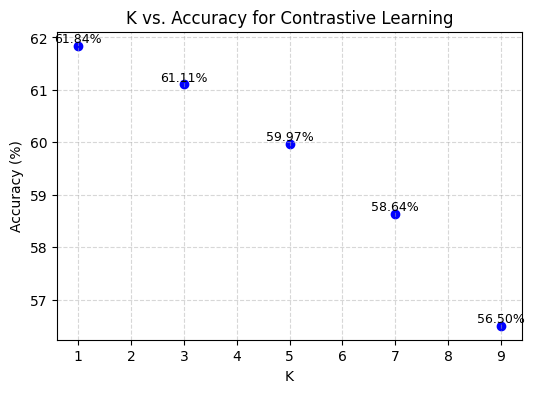

In [ ]:
#############################################################################
# TODO: Plot a K vs Accuracy for Contrastive Learning for K = 1 to K = 10   #
#       of only odd k values on the test dataset using Matplotlib.          #
#       Make sure the plot is discrete, not a continuous line               #
#          (Hint: Use the model.test function and plt.scatter)              #
#############################################################################

k_values = [1, 3, 5, 7, 9]
acc_values = []

for k in k_values:
    acc = contrastive.test(K=k, checkpoint='metric_learning.pt', device='cuda')
    acc_values.append(acc)

plt.figure(figsize=(6,4))
plt.scatter(k_values, acc_values, color='blue', marker='o')

for x, y in zip(k_values, acc_values):
    plt.text(x, y, f'{y:.2f}%', ha='center', va='bottom', fontsize=9)

plt.title('K vs. Accuracy for Contrastive Learning')
plt.xlabel('K')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

Your model is saved on Colab, but it will be deleted when the instance end. Be sure to download it into your local laptop to avoid the training process again. You can upload it back onto Colab later to run some functions on it without having to go through the training process again.

TODO: **Which K value is best for your model based on your plot?**

**ANSWER:**

Based on the plot above, K = 1 is the best for my model, achieving accuracy of 61.84%


TODO: **In our example, we are using Cosine Similarity as a metric. Mathematically, prive that using maximizing Cosine Similiarity is equivalent to minimizing L2-Euclidean Distance when using unit-norm vectors.**


**ANSWER:**

Consider two vectors $\mathbf{x}$ and $\mathbf{y}$ in $\mathbb{R}^d$ such that $\|\mathbf{x}\| = \|\mathbf{y}\| = 1$.

By definition, the cosine similarity between $\mathbf{x}$ and $\mathbf{y}$ is

$$
\text{cos_sim}(\mathbf{x}, \mathbf{y})
= \frac{\mathbf{x} \cdot \mathbf{y}}{\|\mathbf{x}\|\;\|\mathbf{y}\|}.
$$

Since both $\mathbf{x}$ and $\mathbf{y}$ have norm 1, this expression simplifies to

$$
\text{cos_sim}(\mathbf{x}, \mathbf{y})
= \mathbf{x} \cdot \mathbf{y}.
$$

Thus, maximizing $\text{cos_sim}(\mathbf{x}, \mathbf{y})$ is equivalent to maximizing the dot product $\mathbf{x} \cdot \mathbf{y}$.

Next, consider the squared Euclidean distance:

$$
\|\mathbf{x} - \mathbf{y}\|^2
= (\mathbf{x} - \mathbf{y}) \cdot (\mathbf{x} - \mathbf{y})
= \|\mathbf{x}\|^2 + \|\mathbf{y}\|^2 - 2\,(\mathbf{x} \cdot \mathbf{y}).
$$

Since $\|\mathbf{x}\| = \|\mathbf{y}\| = 1$, it follows that

$$
\|\mathbf{x} - \mathbf{y}\|^2
= 1 + 1 - 2\,(\mathbf{x} \cdot \mathbf{y})
= 2 - 2\,(\mathbf{x} \cdot \mathbf{y}).
$$

To minimize $\|\mathbf{x} - \mathbf{y}\|^2$ is therefore equivalent to minimizing $2 - 2(\mathbf{x} \cdot \mathbf{y})$. Since $2$ is a constant, this minimization is precisely the same as maximizing $\mathbf{x} \cdot \mathbf{y}$.

Hence, **maximizing cosine similarity is equivalent to minimizing Euclidean distance** when $\mathbf{x}$ and $\mathbf{y}$ are unit vectors.


TODO: **How effective is metric learning model in predicting your images? What may be some causes of these results? What are three ways that we can improve our contrastive learning model?**

**ANSWER**

#### Model Effectiveness

From the plot, the overall accuracy hovers around 56~62% for different
K values. While not extremely high, it does show that the metric learning model is capturing some meaningful structure—just not to the level of a fully supervised classifier.

#### Possible Causes

1. Insufficient Training or Hyperparameter Tuning: Contrastive methods often require careful tuning of temperature, momentum, and learning rate.

2. Memory Bank Constraints: If the memory bank is not sufficiently large, is updated too slowly/quickly, or does not align well with how data is fed into batches, it can degrade learning.

#### Three ways of improvement

1. Refine Hyperparameters & Training Strategy: tuning temperature value and memory momentum

2. Enhance data augmentations and preprocessing

3. Use a stronger backbone

# Part 4: Comparing Classification and Metric learning Using T-SNE Plots

Now, let us visualize the features our model learned by plotting the features onto a T-SNE plot. A **T-SNE** plot visualize high dimensional datapoint onto a 2d plot.


We have implemented all the functions for you. Run the cells below and answer the questions below.

First, let's plot the penultimate layer (layer before the probabilities) of the ResNet-18 Classification Model. The funtion below plots the features of images from the test dataset and the five closest classes for one of your test image.

<ipython-input-19-35d8b0f52937>:237: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet', len(set(labels)))


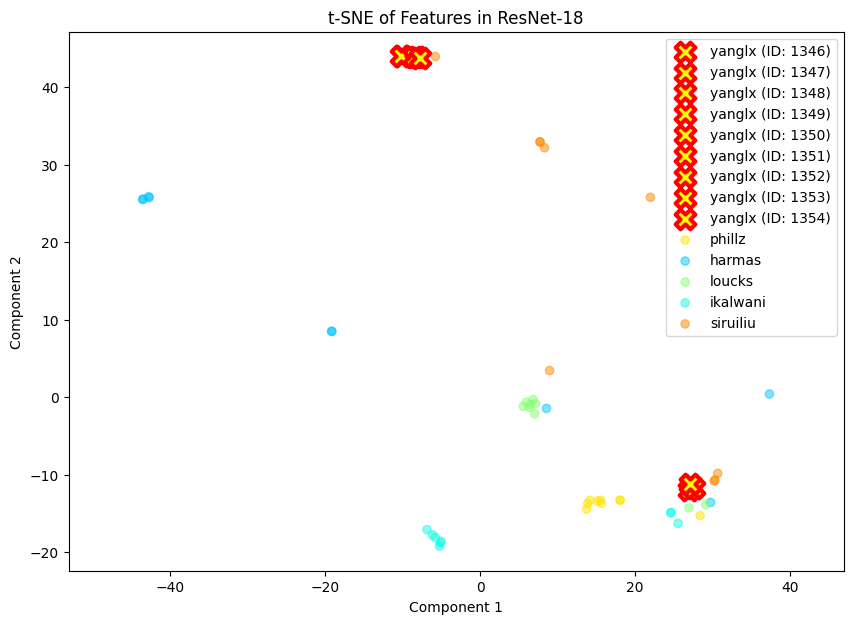

In [ ]:
nearest_images = classifier.getTSNE(test_loader, device=device)

We can also see how these images are similar to your images. Let's take a look at some images of classes where the model believe are similar to you! Rhetorically, do you agree?

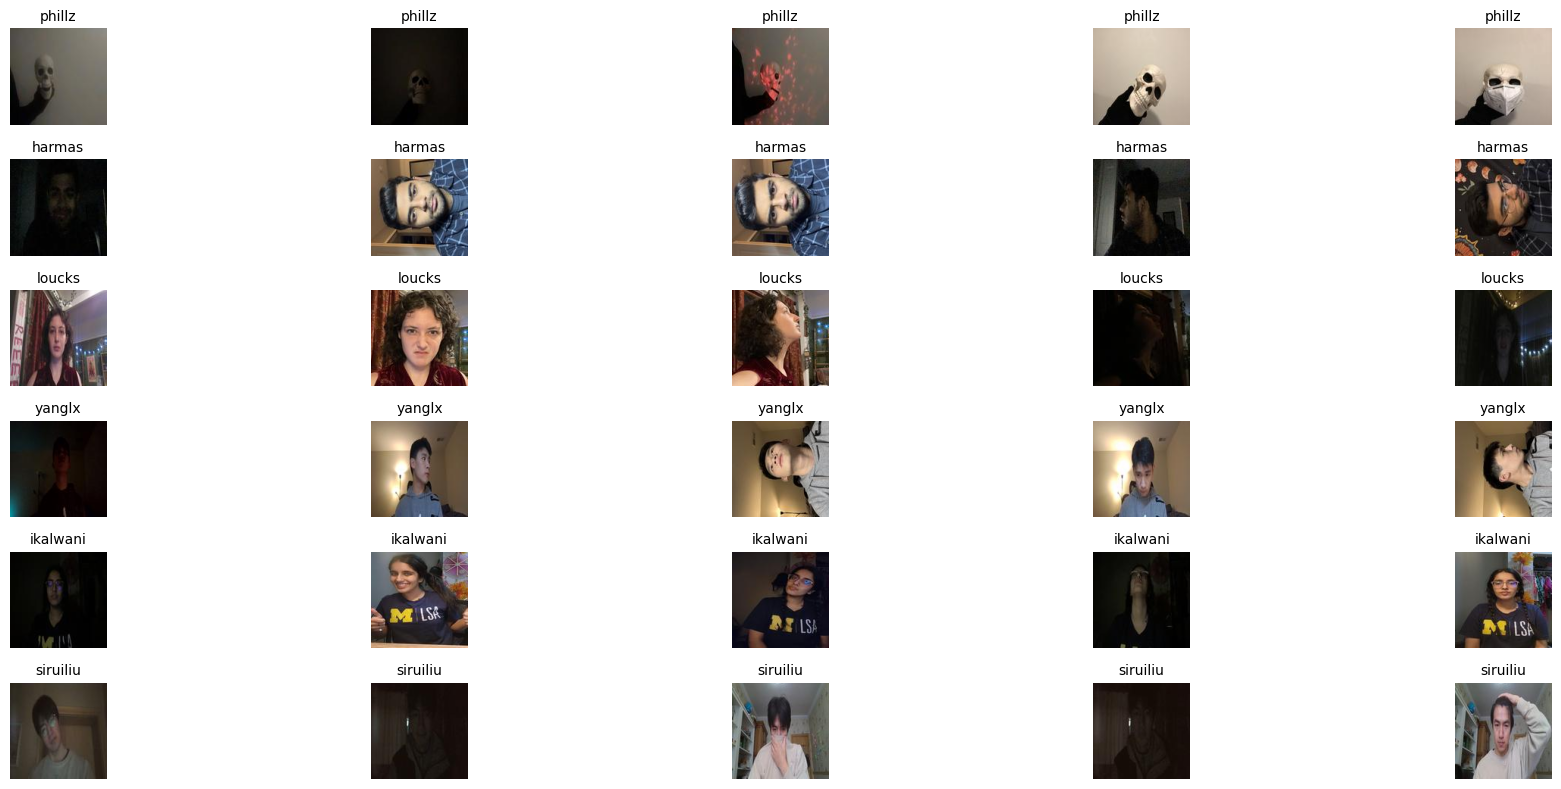

In [ ]:
classifier.plot_nearest_images(nearest_images, test_loader)

Let's plot the T-SNE plot for the metric learning model. We can directly use the output this time since the output is an embedding rather than probabilities.  

The T-SNE plot is plotted such that the numbers represent indices of your images on the test set.

Checking device:  cuda


<ipython-input-13-fe147a9c2e59>:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet', len(set(labels)))


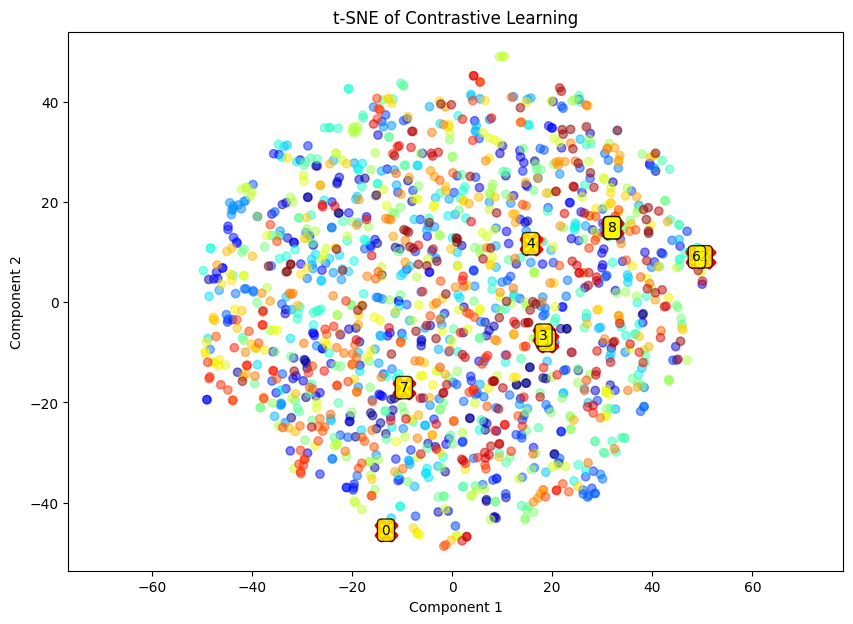

In [ ]:
nearest_images = contrastive.getTSNE(test_loader, device=device)

Let's see how the model choose these clusters. Pick 3 indices from different clusters of your images and run the cells below.

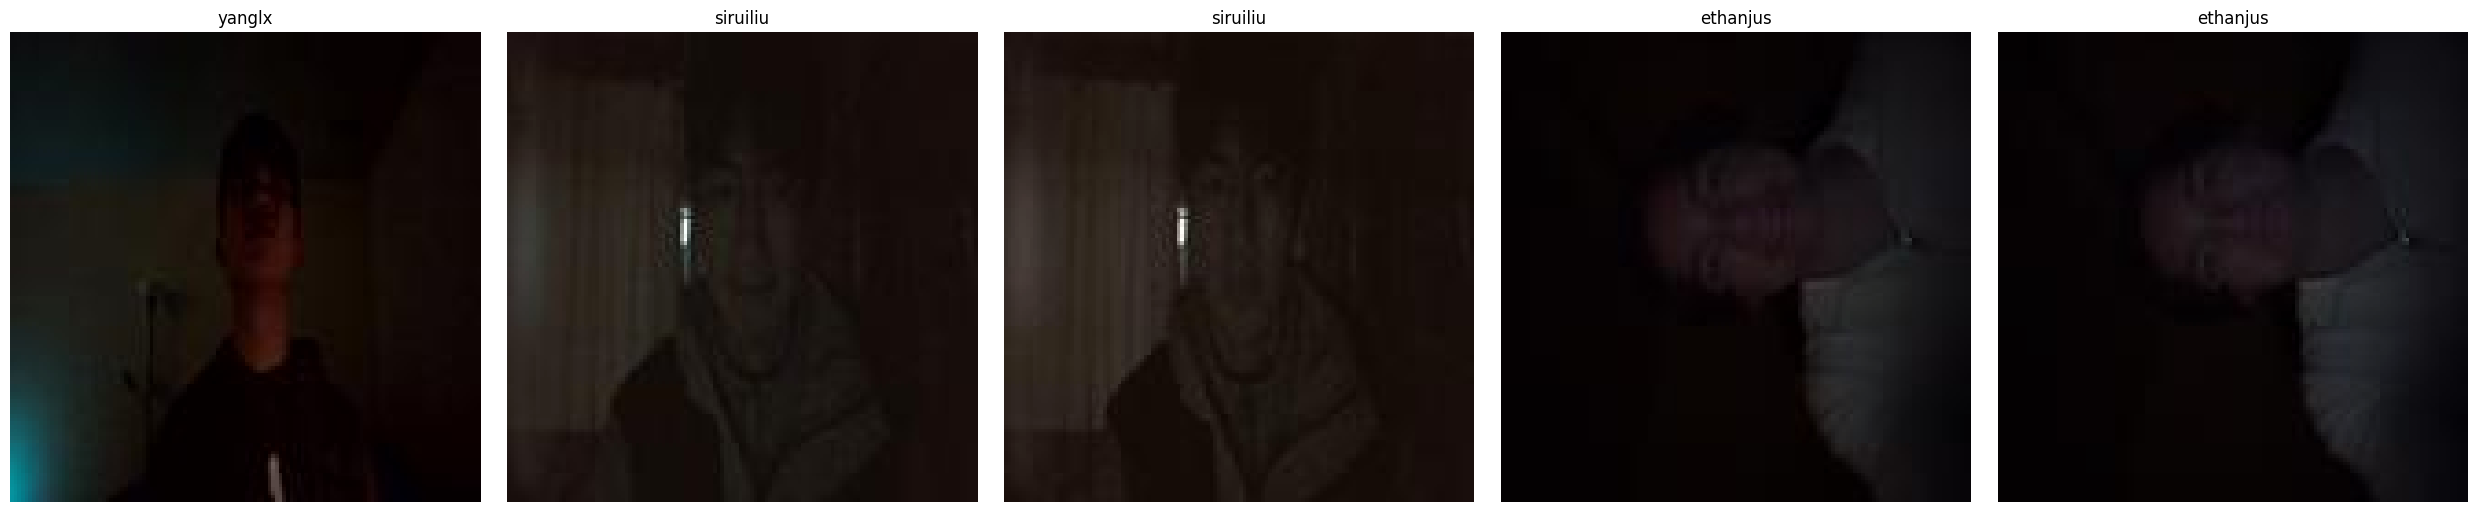

In [ ]:
# TODO: Fill in index 1
INDEX_1 = 0

contrastive.plot_nearest_images(nearest_images, INDEX_1)

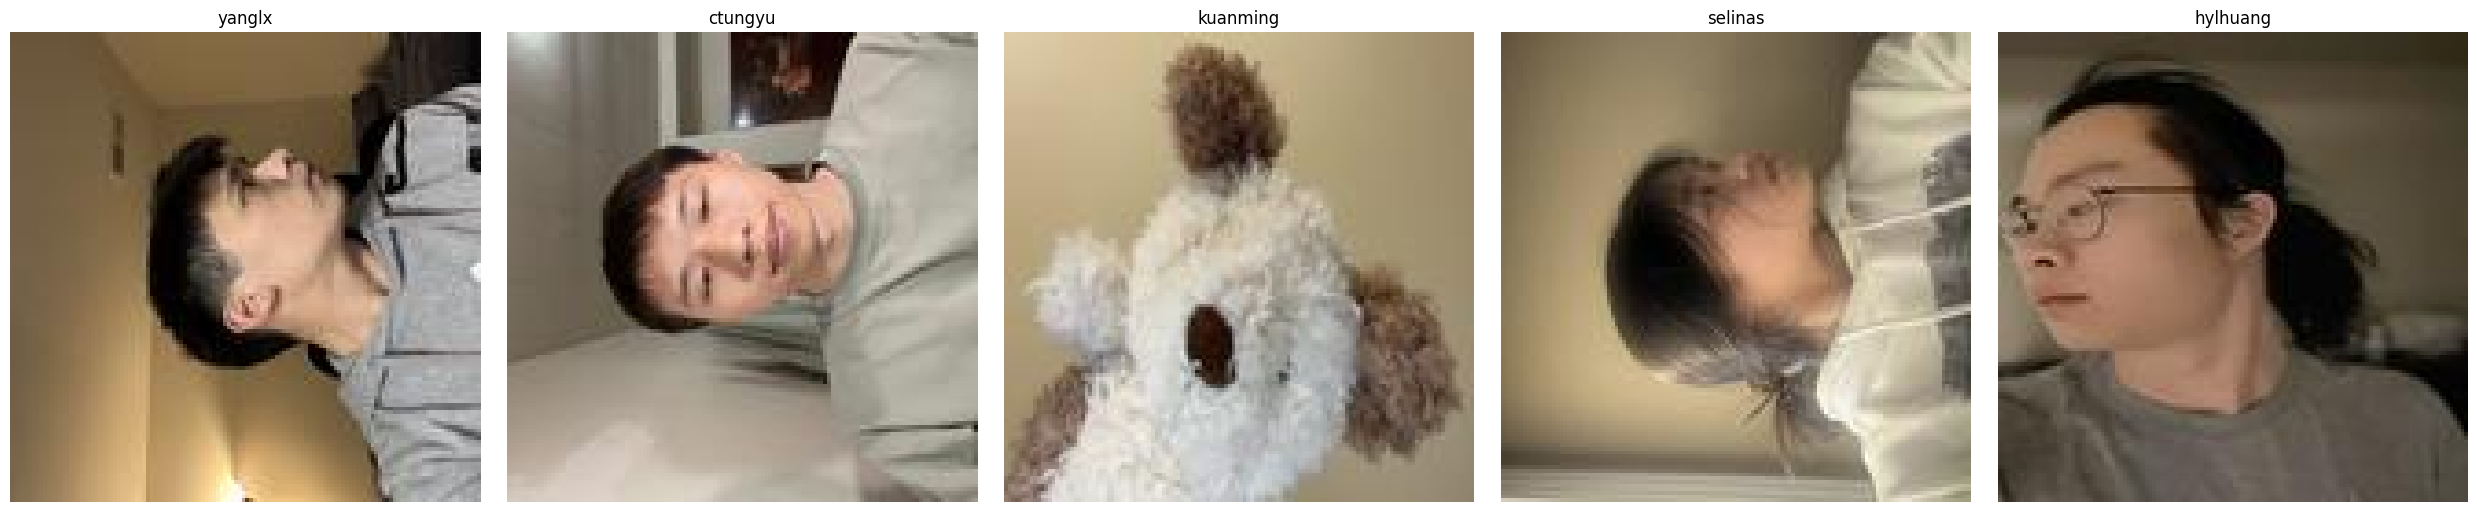

In [ ]:
# TODO: Fill in index 2
INDEX_2 = 4

contrastive.plot_nearest_images(nearest_images, INDEX_2)

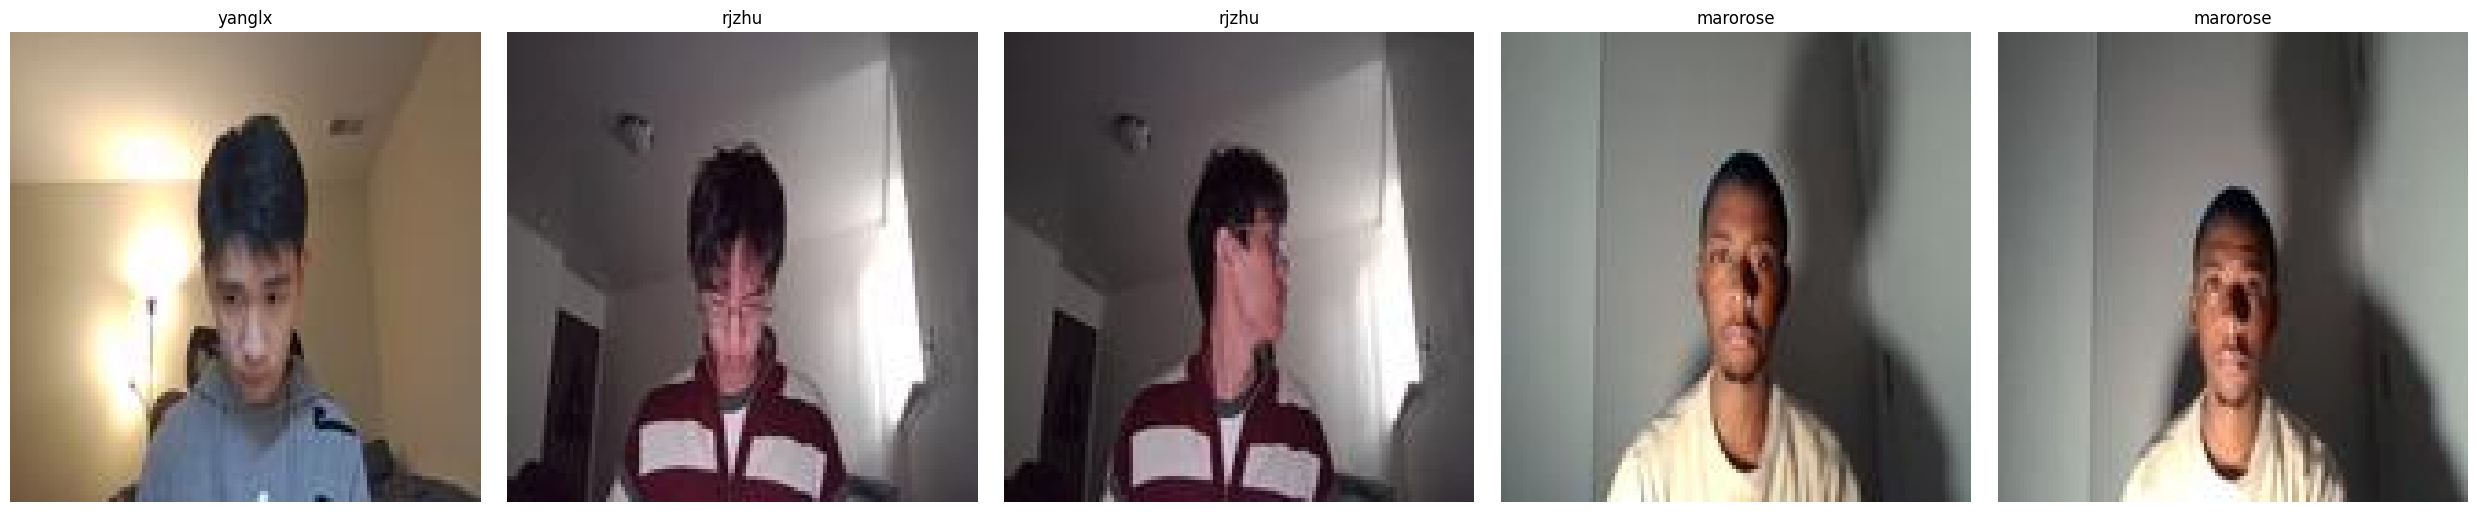

In [ ]:
# TODO: Fill in index 3
INDEX_3 = 3

contrastive.plot_nearest_images(nearest_images, INDEX_3)

TODO: **Unlike the Classification model that looks at supervised classes, Metric Learning uses unsupervised learning to group similar embeddings together. For each of the three indices you chose previously, describe what features the metric learning model could be using to cluster images around that index.**

**ANSWER:**

#### Index = 0

1. Low Illumination / Dark Setting: The images all appear dimly lit.

2. Dominant Dark Tones: Since the background is very dark, the model may emphasize the negative space around the subject.

#### Index = 4

1. Side Profile: Many images show the subject looking sideways, so the embedding may encode face orientation strongly.

2. Neutral / Warmer Background: A beige or pale-colored wall can be a clear, shared background feature.

3. Bright lighting

#### Index = 3

1. Forward / Downward Pose: Multiple images show subjects oriented forward or looking down.

2. Distinct Lighting from Above: A lamp or overhead light can cause certain highlights and shadows, which the model learns as a shared pattern.


TODO: **Compare and Contrast the T-SNE plot for the classification model and metric learning model. Consider how your images are clustered in each plot.**

**ANSWER**

The classification model plot typically shows **tight, discrete** “islands” of points corresponding to each labeled class. Since the backbone was trained to discriminate explicit class categories, it arranges images with the same label very close together and pushes different classes far apart in feature space. As a result, each cluster in the classification t-SNE corresponds to one label, and the boundaries between classes tend to be well-defined.

In contrast, the metric learning model plot usually appears more **diffuse** and interspersed with a mixture of labels. Metric learning pushes each sample to develop a separate representation, or it groups images according to inherent visual similarities such as lighting, orientation, or background color. As a result, images sharing these low-level features may be **scattered across the plot**, even if they have the same label.

In classification, labels dominate the learning objective, driving strong intra-class similarity and inter-class separation. In metric learning, the network has no direct knowledge of labels and thus organizes images primarily by their appearance, rather than by any predefined categories.

TODO: **Which model will be better suited for one-shot learning? Explain your answer.**

**ANSWER**

The metric learning model is better suited for one-shot learning.

When performing one-shot learning, the goal is to recognize a new class or category based on just a single labeled example.

In a metric-learning framework, the model has already learned an embedding space where similar images cluster together and dissimilar images are pushed apart. Therefore, to classify a new image, one can compute its distance to the single “support” example's embedding and make a similarity-based prediction.

A conventional classification model, on the other hand, expects to see multiple labeled examples per class during training. It fine-tunes its final layer weights to separate the specific labels. Therefore it does not generalize well to entirely new classes without additional data or retraining.

# Part 5. DIY Classification Model

In this section, you will create your own classification model. You are not allow to use any pretrained model, but you can get inspired by pre-existing architecture. Your model must take in a 128 x 128 image.

You are allow to add any other data augumentation, optimizer, loss function, etc and use any hyperparameters for your custom model.

Your model will be run on a heldout dataset and the accuracy on the heldout dataset will be used to grade this part of the assignment relative to your fellow students.


In [ ]:
# Feel free to change these values
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Feel free to add additional transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
CUSTOM_BATCH_SIZE = 32

custom_train_dataset = FaceDataset(data_path, train=True, train_split=0.8, transforms=train_transforms)
custom_test_dataset = FaceDataset(data_path, train=False, train_split=0.8, transforms=test_transforms)

custom_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
custom_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class customModel(nn.Module):
    def __init__(self, num_classes):
        super(customModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)  # (N, 32, 64, 64)
        x = self.conv2(x)  # (N, 64, 32, 32)
        x = self.conv3(x)  # (N, 128,16, 16)
        x = self.conv4(x)  # (N, 256, 8, 8)
        x = x.view(x.size(0), -1)  # Flatten => (N, 16384)
        x = self.fc_dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Implement your custom classifier class
# You may pass in additional parameters for each function
import torch.optim.lr_scheduler as lr_scheduler

class CustomClassifier():
    def __init__(self, num_classes, train_loader, test_loader, model):

        self.num_classes = num_classes
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.predictions = []

    def train(self, num_epochs=5, initial_lr=0.001, save_filename=f'{UNIQNAME}.pt', device='cuda'):


        #############################################################################
        # TODO: Implement the classifier training main loop. Make sure you          #
        #       1. Set the model to train mode                                      #
        #       2. Move everything to the specified device                          #
        #       3. Use cross entropy loss and Adam optimizer with proper lr         #
        #       4. Print the running loss for every epoch                           #
        #       5. Save the resulting model weights                                 #
        #       (Hint: every argument should be used; Modules you can use:          #
        #        torch.nn.CrossEntropyLoss, torch.optim.Adam, torch.save)           #
        #############################################################################
        self.model.to(device)
        self.model.train()

        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels, _ in self.train_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            scheduler.step()
            avg_loss = running_loss / len(self.train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

        torch.save(self.model.state_dict(), save_filename)
        print(f"Model saved to {save_filename}")


        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


    def test(self, checkpoint=f'{UNIQNAME}.pt', device='cuda'):

        #############################################################################
        # TODO: Implement the classifier testing main loop. Make sure you           #
        #       1. Set the model to evaluation mode                                 #
        #       2. Move everything to the specified device                          #
        #       4. Take the class with highest score as the prediction              #
        #       5. Save the predictions in the list self.predictions                #
        #       6. Print the overall accuracy on the test set                       #
        #       (Hint: every argument should be used)                               #
        #############################################################################

        if checkpoint:
            self.model.load_state_dict(torch.load(checkpoint, map_location=device))
        self.model.to(device)

        self.model.eval()

        correct = 0
        total = 0
        self.predictions = []

        with torch.no_grad():
            for images, labels, _ in self.test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                self.predictions.extend(predicted.cpu().numpy())

        accuracy = 100.0 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")


        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################


In [ ]:
num_classes = len(train_dataset.class_to_idx)
custom_model = customModel(num_classes=num_classes)

In [ ]:
custom_classifier = CustomClassifier(num_classes=num_classes, train_loader=custom_train_loader, test_loader=custom_test_loader, model=custom_model)

In [ ]:
custom_classifier.train(num_epochs=20, initial_lr=0.001)

Epoch [1/20] - Loss: 5.0066
Epoch [2/20] - Loss: 3.8935
Epoch [3/20] - Loss: 3.1564
Epoch [4/20] - Loss: 2.7068
Epoch [5/20] - Loss: 2.4034
Epoch [6/20] - Loss: 2.0370
Epoch [7/20] - Loss: 1.9142
Epoch [8/20] - Loss: 1.8281
Epoch [9/20] - Loss: 1.7557
Epoch [10/20] - Loss: 1.7096
Epoch [11/20] - Loss: 1.5849
Epoch [12/20] - Loss: 1.5527
Epoch [13/20] - Loss: 1.5272
Epoch [14/20] - Loss: 1.5069
Epoch [15/20] - Loss: 1.4845
Epoch [16/20] - Loss: 1.4369
Epoch [17/20] - Loss: 1.4229
Epoch [18/20] - Loss: 1.4130
Epoch [19/20] - Loss: 1.4039
Epoch [20/20] - Loss: 1.3862
Model saved to yanglx.pt


In [ ]:
custom_classifier.test()

Test Accuracy: 85.86%


In [ ]:
scripted_model = torch.jit.script(custom_classifier.model)
scripted_model.save(f"{UNIQNAME}.pth") # Saves to a .pth file

In [ ]:
# Make sure this runs properly
loaded_model = torch.jit.load(f"{UNIQNAME}.pth")
loaded_model.eval()

# TODO: Update this with test loader to verify the model works
loader = custom_test_loader

with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    for images, labels, _ in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')


100%|██████████| 47/47 [00:01<00:00, 23.88it/s]

Accuracy of the model on the test dataset: 85.86%


TODO: **Write your thought process in creating your model. Explain your decision in your model architecture, any data augumentation or why not, any hyperparameters chosen, etc. that you used in your model. Also, discuss how effective your model is in predicting your images on the test dataset.**

**ANSWER:**

I designed a CNN model with four convolutional layers, each followed by batch normalization, ReLU activation, and max pooling, incrementally increasing filter size from 32 to 256 to capture complex image features. The model concludes with fully-connected layers and dropout to mitigate overfitting. Data augmentation techniques—including random horizontal flips, slight rotations, and color jitter—were applied to improve generalization by simulating real-world image variability.

For hyperparameters, I used an Adam optimizer with an initial learning rate of 0.001 and a step scheduler to gradually reduce this rate, facilitating efficient convergence. Cross-entropy loss with label smoothing helped the model avoid overconfidence and generalize better. The resulting model achieved a test accuracy of approximately 85.86%, demonstrating effective performance, though further tuning and experimentation could yield improvements.


Run Cmd+P/Ctrl+P and save this notebook as a PDF and submit the pdf and your custom .pth model to Gradescope. Be sure to match the question with the page on Gradescope or you may lose points.